In [65]:
import tensorflow as tf 
import numpy as np
import cv2
from skimage.color import rgb2gray
from tensorflow import keras
from model import load_model
from image_utils import imagenet_utils

class gradcam_plusplus():
    '''
    Implimentation of Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks
    url: https://arxiv.org/abs/1710.11063
    '''

    def __init__(self,model,layer_name,input_dim):
        self.gradcamModel= tf.keras.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(layer_name).output, model.output])
        self.input_dim=input_dim
    
    def get_heatmap(self,img,index=None):
 
        with tf.GradientTape() as tape1:
            with tf.GradientTape() as tape2:
                with tf.GradientTape() as tape3:
                    (layer_output, class_prediction) = self.gradcamModel(img) 
                    if(index==None):
                        index=tf.argmax(class_prediction[0])
                    loss = class_prediction[:,index]  
                    gradients1 = tape3.gradient(loss, layer_output) 
                gradients2 = tape2.gradient(gradients1, layer_output)
            gradients3 = tape1.gradient(gradients2, layer_output)

        global_sum = np.sum(layer_output, axis=(0, 1, 2))

        neuron_importance_weights_num = gradients2[0]
        neuron_importance_weights_denom = 2*gradients2[0] + gradients3[0]*global_sum
        neuron_importance_weights_denom = np.where(neuron_importance_weights_denom != 0.0, neuron_importance_weights_denom, 1e-10)
        
        neuron_importance_weights = neuron_importance_weights_num/neuron_importance_weights_denom
        # print(neuron_importance_weights)
        Z = np.sum(neuron_importance_weights, axis=(0,1))
        Z= np.where(Z != 0.0, Z, 1e-10)
        neuron_importance_weights /= Z
        print(Z)
        weights = tf.keras.activations.relu(gradients1[0]) 
        weights = np.sum(weights*neuron_importance_weights, axis=(0,1))
        gradcampp = np.sum(weights*layer_output[0], axis=2)

        gradcampp = tf.keras.activations.relu(gradcampp)
        gradcampp=gradcampp/np.max(gradcampp) 

        return gradcampp

In [66]:
image_name='ILSVRC2012_val_00000171.JPEG'

folder='ILSVRC2012_img_val/'

model_name = 'resnet'
test=load_model(model_name)
model=test.model
input_dim=test.input_dim
layer_name='conv5_block3_3_conv'


g= gradcam_plusplus(model,layer_name,input_dim)
heatmap_dict={}

img_path=os.path.join(folder,image_name)

img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
array = keras.preprocessing.image.img_to_array(img)
array = np.expand_dims(array, axis=0)

preprocess_input = keras.applications.resnet50.preprocess_input

# decode_predictions = keras.applications.vgg16.decode_predictions
preprocessed_input=preprocess_input(array)
index=649
heatmap_lower_dim=g.get_heatmap(preprocessed_input,index)
heatmap = np.squeeze(heatmap_lower_dim)
heatmap = cv2.resize(heatmap, (array.shape[2], array.shape[1]))


[2.1607097e-02 3.3122438e-01 1.0000000e-10 ... 1.0000000e-10 1.0000000e-10
 2.8768060e-01]


In [67]:
heatmap_lower_dim

<tf.Tensor: shape=(7, 7), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.15660457, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]], dtype=float32)>

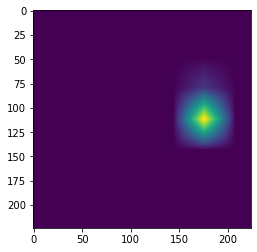

In [68]:

plt.imshow(heatmap)

# CHECK FRFOM LIBRARY

In [71]:
from tf_explain.callbacks.grad_cam import GradCAM
# Load pretrained model or your own
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=True)

# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=375,layer_name=layer_name)  # 281 is the tabby cat index in ImageNet


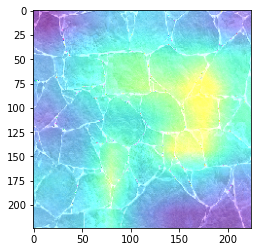

In [72]:
plt.imshow(grid)